In [1]:
import os
import torch
import numpy
import matplotlib.pyplot as plt
import pandas

data_path = './macrophage_data'

#import saveSimulations

inputAmplitude = 3
projectionAmplitude = 1.2

#Setup optimizer
batchSize = 10
MoAFactor = 0.1
spectralFactor = 1e-5
maxIter = 5000
noiseLevel = 10
stateLossFactor = 1e-4
L2 = 1e-6
lr = 2e-3

seed = 49
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
seed_counter = 0 # !!used for addNoiseToAllGradients and steadyStateLoss -- += 1 per training loop, and seed input is seed + seed_counter
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/tmp/ipykernel_2839893/43037186.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


In [2]:
import importlib.util
import sys
import os
lembas_path = '../../lembas_original'

def import_from_path(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[name] = module
    spec.loader.exec_module(module)
    return module

bionetwork = import_from_path('bionetwork', os.path.join(lembas_path, 'bionetwork.py'))
plotting = import_from_path('plotting', os.path.join(lembas_path, 'plotting.py'))

In [3]:
#Load network
networkList, nodeNames, modeOfAction = bionetwork.loadNetwork(os.path.join(data_path, 'macrophage-Model.tsv'))
annotation = pandas.read_csv(os.path.join(data_path, 'macrophage-Annotation.tsv'), sep='\t')
uniprot2gene = dict(zip(annotation['code'], annotation['name']))
bionetParams = bionetwork.trainingParameters(targetSteps = 100, maxSteps = 150, expFactor= 50, tolerance = 1e-5, leak=0.01)

inName = annotation.loc[annotation['ligand'],'code'].values
outName = annotation.loc[annotation['TF'],'code'].values
inName = numpy.intersect1d(nodeNames, inName)
outName = numpy.intersect1d(nodeNames, outName)
outNameGene = [uniprot2gene[x] for x in outName]
nodeNameGene = [uniprot2gene[x] for x in nodeNames]

ligandInput = pandas.read_csv(os.path.join(data_path, 'macrophage-Ligands.tsv'), sep='\t', low_memory=False, index_col=0)
TFOutput = pandas.read_csv(os.path.join(data_path, 'macrophage-TFs.tsv'), sep='\t', low_memory=False, index_col=0)

#Subset input and output to intersecting nodes
inName = ligandInput.columns.values
outName = TFOutput.columns.values

# doesnt change anything
inName = numpy.intersect1d(nodeNames, inName)
outName = numpy.intersect1d(nodeNames, outName)

# map from uniprot ID to gene name 
inNameGene = [uniprot2gene[x] for x in inName]
outNameGene = [uniprot2gene[x] for x in outName]

# c
ligandInput = ligandInput.loc[:,inName] # conditions x ligand (values are binary of presence or absence)
TFOutput = TFOutput.loc[:,outName] # conditions x TFs (values are TF activity score)
sampleName = ligandInput.index.values


In [4]:
model = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, seed = seed, device = device, activationFunction = 'MML')
model.inputLayer.weights.requires_grad = False
model.network.preScaleWeights()
# model.setDevice(device)
# model = model.to(device)

spectralCapacity = model.network.param['spectralTarget']

X = torch.tensor(ligandInput.values.copy(), dtype=torch.float32, device = device)
Y = torch.tensor(TFOutput.values, dtype=torch.float32, device = device)
# X = X.to(device)
# Y = Y.to(device)

In [5]:
criterion = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1, weight_decay=0)
resetState = optimizer.state.copy()

mLoss = criterion(torch.mean(Y, dim=0) * torch.ones(Y.shape, device = Y.device), Y)
print(mLoss)


stats = plotting.initProgressObject(maxIter)
N = X.shape[0]

tensor(0.0463, device='cuda:0')


# Train

In [6]:
counter = 0
e = 0
for e in range(e, maxIter):
    curLr = bionetwork.oneCycle(e, maxIter, maxHeight = lr, startHeight=lr/10, endHeight=1e-6, peak = 1000)
    
    optimizer.param_groups[0]['lr'] = curLr
    
    curLoss = []
    curEig = []
    numpy.random.seed(seed + e)
    trainloader = numpy.array_split(numpy.random.permutation(N), numpy.ceil(N/batchSize).astype(int))
    for dataIndex in trainloader:
        model.train()
        optimizer.zero_grad()
        
        dataIn = X[dataIndex, :].view(len(dataIndex), X.shape[1])
        dataOut = Y[dataIndex, :].view(len(dataIndex), Y.shape[1])
        
        Yin = model.inputLayer(dataIn)
        # print(seed + counter)
        torch.manual_seed(seed + counter)
        torch.cuda.manual_seed(seed + counter)
        network_noise = torch.randn(Yin.shape, device = Yin.device)
        Yin = Yin + noiseLevel * curLr * network_noise
        YhatFull = model.network(Yin)
        Yhat = model.projectionLayer(YhatFull)
        
        fitLoss = criterion(dataOut, Yhat)
        
        signConstraint = model.network.signRegularization(MoAFactor)
        ligandConstraint = 1e-5 * torch.sum(torch.square(model.network.bias[model.inputLayer.nodeOrder]))
        stabilityLoss, spectralRadius = model.network.steadyStateLoss(YhatFull.detach(), spectralFactor, topNvalues = 10, seed = seed + counter)
        stateLoss = model.applyUniformLoss(curLr * stateLossFactor, YhatFull)
        regLoss = model.L2Reg(L2)
        
        loss = fitLoss + signConstraint + ligandConstraint + regLoss + stabilityLoss + stateLoss
        loss.backward()
        model.addNoiseToAllGradients(1e-9, seed = seed + counter)
        optimizer.step()
        
        curEig.append(spectralRadius)
        curLoss.append(fitLoss.item())
        
        stats = plotting.storeProgress(stats, e, curLoss, curEig, curLr, violations=torch.sum(model.network.getViolations()).item())
        counter += 1
    if e % 250 == 0:
        plotting.printStats(e, stats)
    
    if numpy.logical_and(e % 200 == 0, e>0):
        optimizer.state = resetState.copy()

torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=os.path.join(data_path, 'og_mac_state_dict.pth'))
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=os.path.join(data_path, 'og_mac_trained.pth'))

i=0, l=0.28698, s=0.776, r=0.00020, v=0
i=250, l=0.04648, s=0.570, r=0.00046, v=0
i=500, l=0.02794, s=0.753, r=0.00110, v=0
i=750, l=0.02512, s=0.785, r=0.00174, v=2
i=1000, l=0.01594, s=0.822, r=0.00200, v=0
i=1250, l=0.01238, s=0.842, r=0.00198, v=0
i=1500, l=0.00983, s=0.854, r=0.00191, v=0
i=1750, l=0.00869, s=0.829, r=0.00181, v=0
i=2000, l=0.00831, s=0.837, r=0.00167, v=0
i=2250, l=0.00806, s=0.817, r=0.00150, v=0
i=2500, l=0.01081, s=0.862, r=0.00131, v=1
i=2750, l=0.00753, s=0.866, r=0.00110, v=0
i=3000, l=0.00657, s=0.842, r=0.00090, v=0
i=3250, l=0.00629, s=0.846, r=0.00069, v=1
i=3500, l=0.00600, s=0.853, r=0.00050, v=0
i=3750, l=0.00585, s=0.860, r=0.00033, v=0
i=4000, l=0.00582, s=0.860, r=0.00019, v=0
i=4250, l=0.00571, s=0.866, r=0.00009, v=1
i=4500, l=0.00582, s=0.875, r=0.00002, v=0
i=4750, l=0.00572, s=0.870, r=0.00000, v=0


In [7]:
model.eval()
Yhat, YhatFull = model(X)

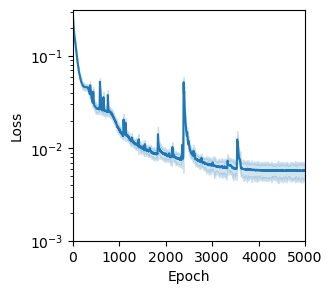

In [9]:
plt.rcParams["figure.figsize"] = (3,3)
plt.figure()


T = numpy.array(range(stats['loss'].shape[0]))
plotting.shadePlot(T, plotting.movingaverage(stats['loss'], 5), plotting.movingaverage(stats['lossSTD'], 10))
#plt.plot(T[nanFilter], plotting.movingaverage(stats['loss'][nanFilter], 5))
plt.xlim([0, len(T)])
plt.ylim(bottom=1e-3)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')

Text(0.5, 0, 'Epoch')

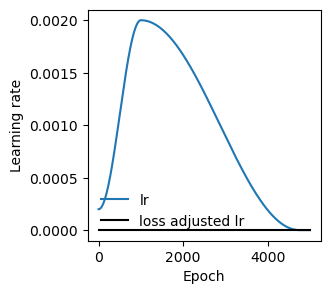

In [10]:
plt.figure()
plt.plot(T, stats['rate'])
plt.plot([0, maxIter], [0, 0], 'black')
plt.legend(numpy.array(['lr', 'loss adjusted lr']), frameon=False)
plt.ylabel('Learning rate')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

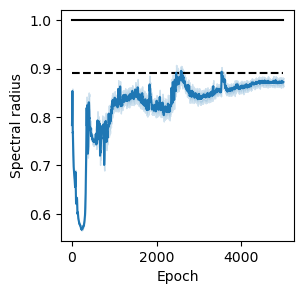

In [11]:
plt.figure()
plt.plot([0, maxIter], [1, 1], 'black')
plt.plot([0, len(T)], spectralCapacity * numpy.array([1, 1]), 'black', linestyle='--')
plotting.shadePlot(T, plotting.movingaverage(stats['eig'], 5), plotting.movingaverage(stats['eigSTD'], 5))
plt.ylabel('Spectral radius')
plt.xlabel('Epoch')

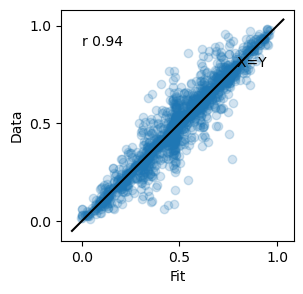

In [12]:
plt.figure()
Yhat, YhatFull = model(X)
plt.scatter(Yhat.detach().cpu().numpy(), Y.detach().cpu().numpy(), alpha=0.2)
plotting.lineOfIdentity()
plotting.addCorrelation(Yhat.cpu(), Y.cpu())
plt.xlabel('Fit')
plt.ylabel('Data')
plt.gca().axis('equal')
plt.gca().set_xticks([0, 0.5, 1])
plt.gca().set_yticks([0, 0.5, 1])

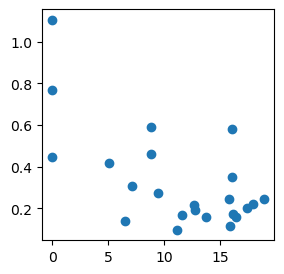

In [14]:
plt.figure()
Yctrl, _ = model(torch.zeros((1, X.shape[1]), dtype=torch.float32, device = X.device))
signalDistance = torch.sum(torch.abs(Yhat - Yctrl),dim=1).detach().cpu().numpy().flatten()
fitDistance = torch.sum(torch.square(Yhat-Y),dim=1).detach().cpu().numpy().flatten()
plt.scatter(signalDistance, fitDistance)